# Airline Reviews Analysis


## 1. Setup and Data Preparation

In [57]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.manifold import MDS
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
import re
from collections import Counter
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt_tab')

# Set random seed for reproducibility
np.random.seed(42)

# Display settings
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pmmdu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pmmdu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\pmmdu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\pmmdu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### 1.1 Data Loading and Initial Exploration

In [10]:
# Load the airline reviews data
reviews_df = pd.read_csv('AirlineReviews.csv')
print(reviews_df.head())

        Aircraft    AirlineName      CabinType      DateFlown  \
0            NaN    AB Aviation  Economy Class  November 2019   
1           E120    AB Aviation  Economy Class      June 2019   
2  Embraer E120     AB Aviation  Economy Class      June 2019   
3            NaN  Aerocaribbean  Economy Class            NaN   
4            NaN  Aerocaribbean            NaN            NaN   

              DatePub  EntertainmentRating  FoodRating  GroundServiceRating  \
0  11th November 2019                    0           4                    4   
1      25th June 2019                    0           1                    1   
2      25th June 2019                    0           1                    1   
3  31st December 2010                    0           0                    0   
4  25th November 2010                    0           0                    0   

   OriginCountry  OverallScore Recommended  \
0    Netherlands           9.0         yes   
1  UnitedKingdom           1.0          no

In [11]:
# Rename columns for consistency
reviews_df = reviews_df.rename(columns={'ValueRating': 'Rating','unique_id':'Review_id'})

# Display basic statistics
print("Rating distribution:")
print(reviews_df['Rating'].value_counts().sort_index())
print(f"\nTotal reviews: {len(reviews_df)}")
print(f"Average rating: {reviews_df['Rating'].mean():.2f}")

Rating distribution:
Rating
0     2382
1    49670
2    14532
3    14631
4    22386
5    25854
Name: count, dtype: int64

Total reviews: 129455
Average rating: 2.64


### 1.2 Text Preprocessing

In [12]:
def preprocess_text(text):
    if pd.isna(text):
        return ""

    text = str(text).lower()

    # Emoticons and time
    text = re.sub(r':( |-|o)*\(', ' SADSMILE ', text)         # Sad emoticons
    text = re.sub(r':( |-|o)*\)', ' HAPPYSMILE ', text)       # Happy emoticons
    text = re.sub(r'([0-9]+:)*[0-9]+ *am', ' TIME_AM ', text) # Time AM
    text = re.sub(r'([0-9]+:)*[0-9]+ *pm', ' TIME_PM ', text) # Time PM
    text = re.sub(r'-+:-+', ' TIME ', text)                   # General time format

    # Dollar and numeric values
    text = re.sub(r'\$ ?[0-9]*[\.,]*[0-9]+', ' DOLLARVALUE ', text) # Dollar values
    text = re.sub(r'(\"| |\$)-+\.-+', ' NUMBER ', text)             # Specific numeric patterns
    text = re.sub(r'[0-9]*[\.,]*[0-9]+', ' NUMBER ', text)          # Remaining numbers

    # Special characters and whitespace
    text = re.sub(r'-', ' ', text)             # Replace hyphens with space
    text = re.sub(r'&', ' and ', text)         # Replace ampersands
    text = re.sub(r'"', ' ', text)             # Remove double quotes
    text = re.sub(r'\|', ' ', text)            # Remove pipe symbols
    text = re.sub(r'_', ' ', text)             # Remove underscores
    text = re.sub(r';', ' ', text)             # Remove semicolons
    text = re.sub(r'\s+', ' ', text)           # Remove excess whitespace
    text = re.sub(r'\.+', '.', text)           # Collapse multiple periods

    return text.strip()

# Apply preprocessing
reviews_df['Review_processed'] = reviews_df['Review'].apply(preprocess_text)

# Display example of preprocessing
print("\nExample of text preprocessing:")
print("Original:", reviews_df['Review'].iloc[0][:100])
print("Processed:", reviews_df['Review_processed'].iloc[0][:100])


Example of text preprocessing:
Original: Moroni to Moheli. Turned out to be a pretty decent airline. Online booking worked well, checkin and 
Processed: moroni to moheli. turned out to be a pretty decent airline. online booking worked well, checkin and 


In [40]:
from nltk.stem.snowball import SnowballStemmer

# Initialize English stopwords and the Snowball stemmer
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

# Text preprocessing function
def tokenize_and_stem_r_like(text, keep_negation=False):
    if pd.isna(text):
        return []

    # Adjust stopword list if keeping negation terms
    if keep_negation:
        custom_stop_words = stop_words - {'no', 'not', 'never'}
    else:
        custom_stop_words = stop_words

    # Lowercase and remove non-letter characters
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Filter out stopwords, short tokens, and apply stemming
    filtered = [
        stemmer.stem(word) for word in tokens
        if word not in custom_stop_words and len(word) > 2 and word.isalpha()
    ]

    return filtered

#Apply preprocessing to each review
reviews_df['Review_stemmed_tokens'] = reviews_df['Review'].fillna('').apply(tokenize_and_stem_r_like)

#Compute document frequency for each word
total_reviews = len(reviews_df)
freq_threshold = 0.01 * total_reviews  # Words must appear in at least 1% of reviews

word_in_reviews = Counter()
for tokens in reviews_df['Review_stemmed_tokens']:
    for word in set(tokens):
        word_in_reviews[word] += 1

#Identify infrequent words to remove
infrequent_words = {w for w, c in word_in_reviews.items() if c < freq_threshold}

#Remove infrequent words from each review
def remove_infrequent_words(tokens, infreq_words):
    return [w for w in tokens if w not in infreq_words]

reviews_df['Review_stemmed_tokens_clean'] = reviews_df['Review_stemmed_tokens'].apply(
    lambda tokens: remove_infrequent_words(tokens, infrequent_words)
)

#Optionally collapse cleaned tokens back to text
reviews_df['Review_stemmed_clean'] = reviews_df['Review_stemmed_tokens_clean'].apply(
    lambda tokens: ' '.join(tokens)
)

## 2. Exploratory Data Analysis

### 2.1 Word Frequency Analysis

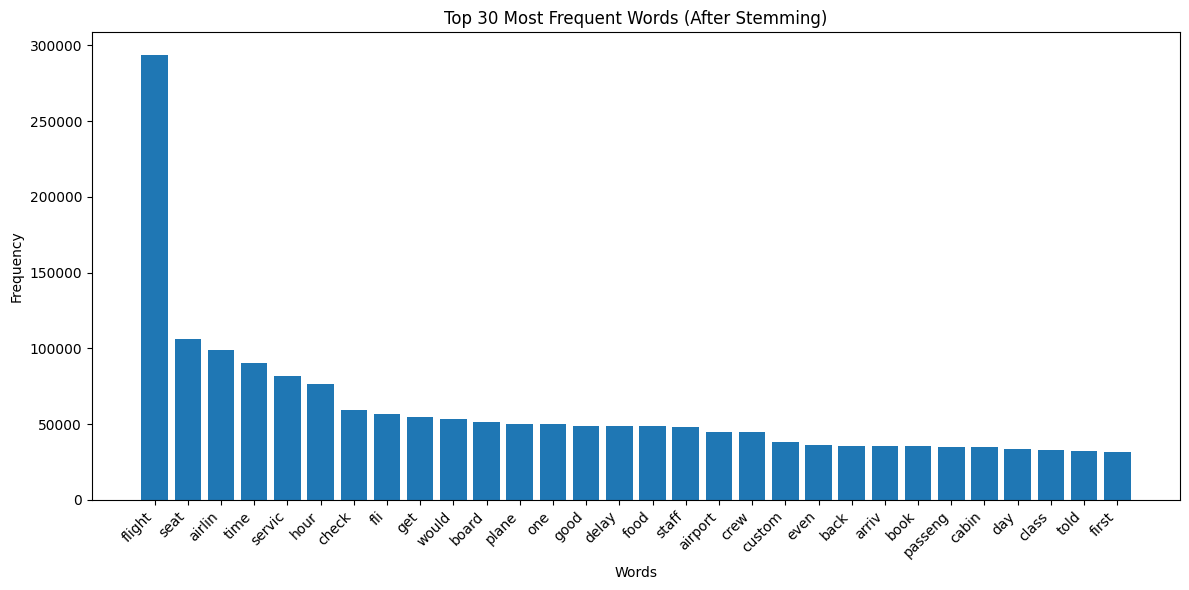

Top 20 most frequent words:
flight: 293864
seat: 105982
airlin: 99150
time: 90393
servic: 81534
hour: 76320
check: 59009
fli: 56818
get: 54466
would: 53058
board: 51642
plane: 50411
one: 50215
good: 49024
delay: 48896
food: 48785
staff: 48314
airport: 45030
crew: 44900
custom: 38292


In [35]:
# Word frequency analysis
from collections import Counter
import matplotlib.pyplot as plt

def get_word_frequencies(text_series, top_n=20):
    """Get most frequent words from a text series"""
    all_words = ' '.join(text_series.fillna('')).split()
    word_freq = Counter(all_words)
    return word_freq.most_common(top_n)

# Get top words
top_words = get_word_frequencies(reviews_df['Review_stemmed_clean'], top_n=30)

# Plot word frequencies
plt.figure(figsize=(12, 6))
words, frequencies = zip(*top_words)
plt.bar(range(len(words)), frequencies)
plt.xticks(range(len(words)), words, rotation=45, ha='right')
plt.title('Top 30 Most Frequent Words (After Stemming)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

print("Top 20 most frequent words:")
for word, freq in top_words[:20]:
    print(f"{word}: {freq}")

### 2.2 Multidimensional Scaling (MDS)

In [ ]:
# Tokenize and count
docs = reviews_df['Review_stemmed_clean'].fillna('').tolist()
tokenized_docs = [word_tokenize(doc) for doc in docs]

# Build top 200 vocab
all_tokens = [token for doc in tokenized_docs for token in doc]
token_counts = Counter(all_tokens)
top_words = [w for w, _ in token_counts.most_common(200)]
top_words_set = set(top_words)
word2idx = {word: i for i, word in enumerate(top_words)}

# Init co-occurrence matrix (boolean count within window)
cooc_mat = np.zeros((200, 200), dtype=float)
window_size = 5

for doc in tokenized_docs:
    doc_len = len(doc)
    for i, word in enumerate(doc):
        if word not in top_words_set:
            continue
        w_idx = word2idx[word]
        start = max(0, i - window_size)
        end = min(doc_len, i + window_size + 1)
        for j in range(start, end):
            if i == j:
                continue
            neighbor = doc[j]
            if neighbor in top_words_set:
                n_idx = word2idx[neighbor]
                cooc_mat[w_idx, n_idx] += 1

# Set diagonals to document frequency
doc_freq = np.array([sum(word in doc for doc in tokenized_docs) for word in top_words])
np.fill_diagonal(cooc_mat, doc_freq)

row_sums = np.sum(cooc_mat, axis=1)
col_sums = np.sum(cooc_mat, axis=0) 
total_sum = np.sum(cooc_mat)

# Avoid division by zero
row_sums_safe = np.where(row_sums == 0, 1e-10, row_sums)
col_sums_safe = np.where(col_sums == 0, 1e-10, col_sums)

diss_mat = np.zeros_like(cooc_mat)
for i in range(200):
    for j in range(200):
        if i == j:
            diss_mat[i, j] = 0
        else:
            diss_mat[i, j] = 1 / (1 + (total_sum * cooc_mat[i, j]) / (row_sums_safe[i] * col_sums_safe[j]))

# Make symmetric
diss_mat = (diss_mat + diss_mat.T) / 2

# Metric MDS with fixed random_state (equivalent to smacofSym)
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=0, 
          metric=True, n_init=10, max_iter=1000)
coords = mds.fit_transform(diss_mat)




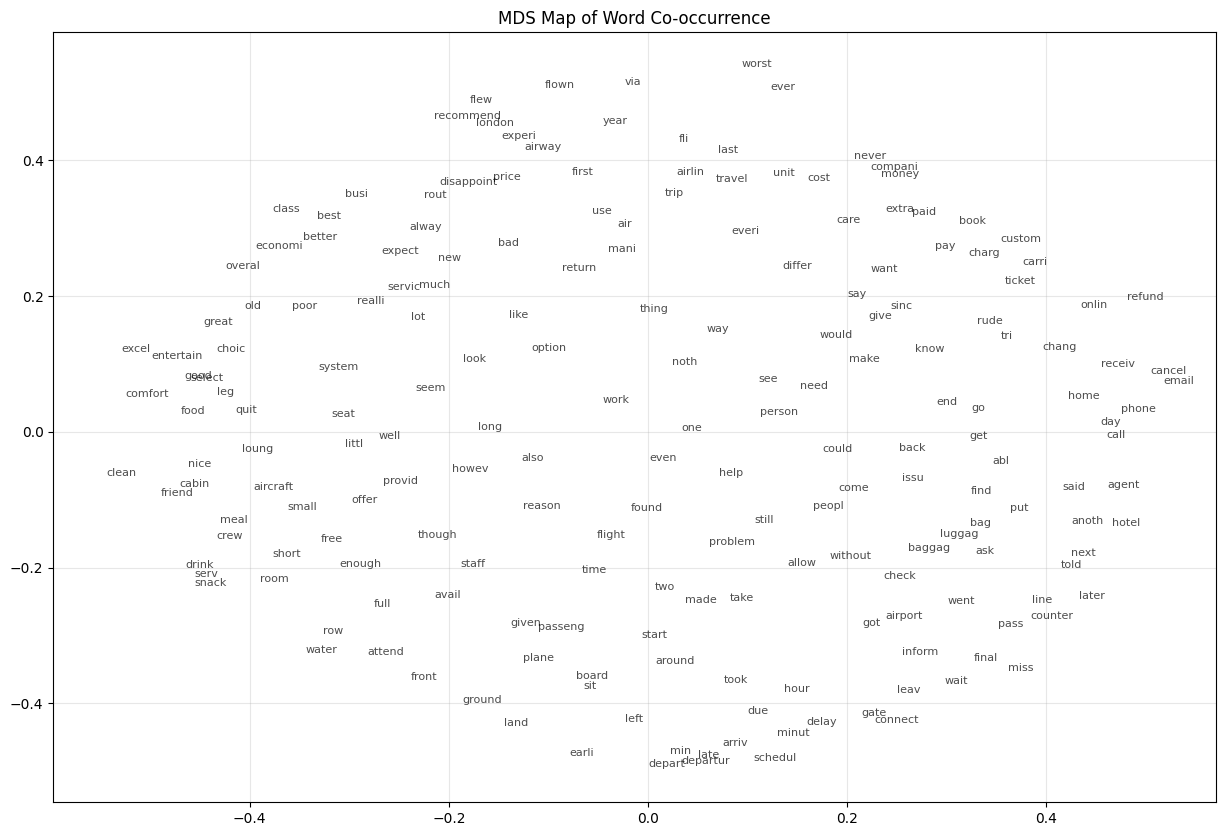

In [46]:
# Plot
plt.figure(figsize=(15, 10))
plt.scatter(coords[:, 0], coords[:, 1], alpha=0)
for i, word in enumerate(top_words):
    plt.text(coords[i, 0], coords[i, 1], word, fontsize=8, alpha=0.7)
plt.title('MDS Map of Word Co-occurrence')
plt.grid(True, alpha=0.3)
plt.show()


1. Service & Comfort (Left Side)
- Words: comfort, food, seat, crew, cabin, entertainment, friend, clean, nice, meal, drink, snack, service, choice
- Theme: These words relate to in-flight experience, passenger comfort, and the quality of amenities and staff service. 
2. Booking, Money & Customer Support (Top-Right)
- Words: book, ticket, refund, money, paid, cost, charge, pay, extra, custom, company, online, email, phone, agent, call
- Theme: This cluster is about the booking process, pricing, payment issues, and customer service interactions (especially regarding refunds or complaints).

3. Delays, Timing & Logistics (Bottom-Right)
- Words: delay, minute, hour, gate, connect, wait, miss, final, inform, airport, counter, schedule, departure, arrival, land, left
- Theme: Words here relate to flight punctuality, delays, missed connections, and communication around timing and logistics—often reflecting operational challenges.

4. Negative Experiences & Complaints (Top-Center/Right)
- Words: worst, ever, never, rude, disappointing, bad, problem, issue, trouble, cancel, change, receive, home, next, told
- Theme: These words are strongly associated with negative sentiment and complaints, often about poor service, unhelpful staff, or unresolved issues.

## 3. Sentiment Analysis

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\pmmdu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Mean sentiment of positive reviews: 0.714
Mean sentiment of negative reviews: -0.381


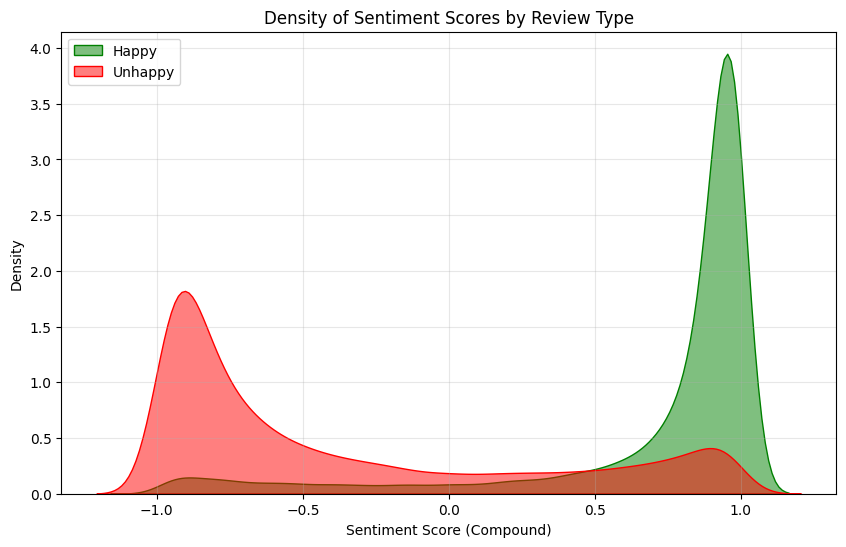

In [39]:
nltk.download('vader_lexicon')

reviews_df_subset = reviews_df[['Review', 'Rating']].dropna()

# Step 1: VADER Sentiment 
sia = SentimentIntensityAnalyzer()
reviews_df_subset['sentiment'] = reviews_df_subset['Review'].apply(
    lambda x: sia.polarity_scores(str(x))['compound']
)

# Step 2: Positive and Negative Subsets
pos_reviews = reviews_df_subset[reviews_df_subset['Rating'] >= 4]
neg_reviews = reviews_df_subset[reviews_df_subset['Rating'] <= 2]

# Step 3: Mean polarity
print("Mean sentiment of positive reviews:", round(pos_reviews['sentiment'].mean(), 3))
print("Mean sentiment of negative reviews:", round(neg_reviews['sentiment'].mean(), 3))

# Step 4: Density Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(pos_reviews['sentiment'], fill=True, label='Happy', alpha=0.5, color='green')
sns.kdeplot(neg_reviews['sentiment'], fill=True, label='Unhappy', alpha=0.5, color='red')
plt.title("Density of Sentiment Scores by Review Type")
plt.xlabel("Sentiment Score (Compound)")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Happy reviews use language that is consistently recognized as positive by VADER, while Unhappy reviews use negative language. In other words, most customers who leave positive ratings express themselves in unambiguously positive terms, while negative reviewers are similarly clear in their dissatisfaction

## 4. Topic Modeling with Latent Dirichlet Allocation (LDA)

In [62]:
from gensim import corpora, models
from gensim.models import CoherenceModel

# Step 1: Create DTM & Split Data
# Subset data
reviews_subset = reviews_df[['Review_id', 'Review_stemmed_tokens_clean']].iloc[:10000].copy()

# Convert to list of tokens
docs = reviews_subset['Review_stemmed_tokens_clean'].tolist()

# Create dictionary and corpus
dictionary = corpora.Dictionary(docs)
dictionary.filter_extremes(no_below=5, no_above=0.5)  # optional

corpus = [dictionary.doc2bow(doc) for doc in docs]

# Train/validation split
train_indices, val_indices = train_test_split(range(len(corpus)), test_size=0.2, random_state=2345)
corpus_train = [corpus[i] for i in train_indices]
corpus_val = [corpus[i] for i in val_indices]
docs_train = [docs[i] for i in train_indices]
docs_val = [docs[i] for i in val_indices]


In [63]:
#Step 2: Train LDA Models and Track Metrics
topic_nums = [5, 8, 10, 15, 20, 30]
results = []

models_dict = {}

for k in topic_nums:
    lda_model = models.LdaModel(
        corpus=corpus_train,
        id2word=dictionary,
        num_topics=k,
        random_state=42,
        iterations=700 + 10*k,
        passes=10,
        alpha='auto',
        eta=0.05,
        eval_every=None
    )

    # Coherence
    coh_train = CoherenceModel(model=lda_model, texts=docs_train, dictionary=dictionary, coherence='c_v').get_coherence()
    coh_val = CoherenceModel(model=lda_model, texts=docs_val, dictionary=dictionary, coherence='c_v').get_coherence()

    # Perplexity
    ll_train = lda_model.log_perplexity(corpus_train)
    ll_val = lda_model.log_perplexity(corpus_val)

    results.append({
        'n_topics': k,
        'll_train': ll_train,
        'll_val': ll_val,
        'coh_train': coh_train,
        'coh_val': coh_val
    })

    models_dict[k] = lda_model

results_df = pd.DataFrame(results)


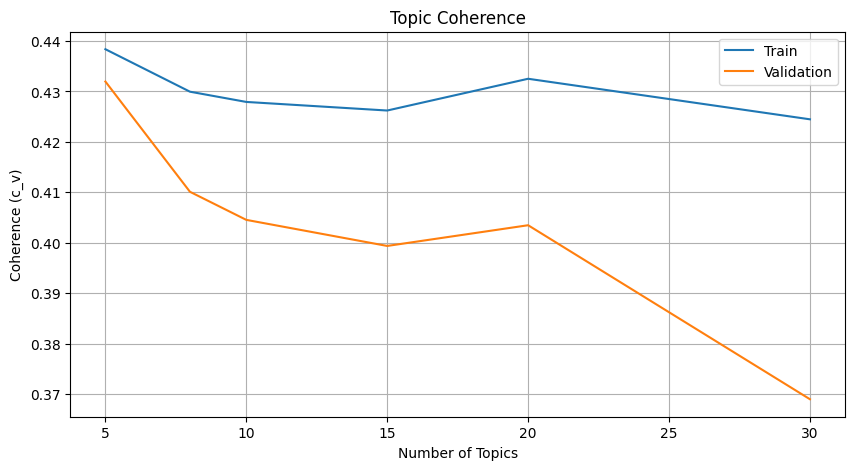

Best number of topics: 5


In [53]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=results_df, x='n_topics', y='coh_train', label='Train')
sns.lineplot(data=results_df, x='n_topics', y='coh_val', label='Validation')
plt.title("Topic Coherence")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence (c_v)")
plt.legend()
plt.grid(True)
plt.show()

# Best model
best_k = results_df.loc[results_df['coh_val'].idxmax(), 'n_topics']
print(f"Best number of topics: {best_k}")


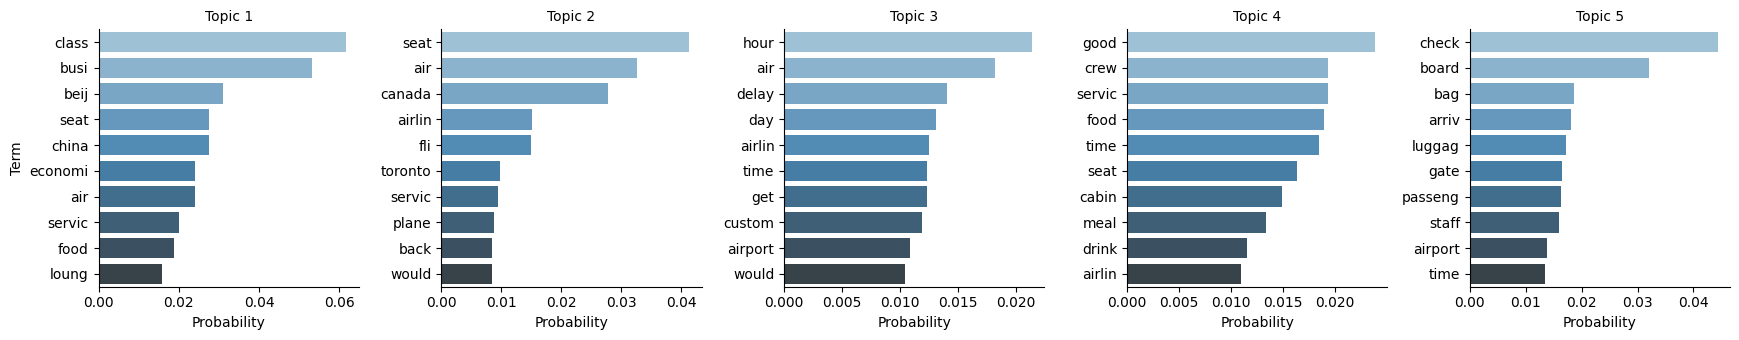

In [56]:
best_model = models_dict[best_k]
top_terms = []

for topic_id in range(best_k):
    words_probs = best_model.show_topic(topic_id, topn=10)
    for word, prob in words_probs:
        top_terms.append({'topic': topic_id + 1, 'term': word, 'probability': prob})

top_terms_df = pd.DataFrame(top_terms)

g = sns.FacetGrid(top_terms_df, col='topic', col_wrap=5, sharex=False, sharey=False, height=3.5)
g.map_dataframe(sns.barplot, x='probability', y='term', palette='Blues_d', orient='h')
g.set_titles("Topic {col_name}")
g.set_axis_labels("Probability", "Term")
plt.tight_layout()
plt.show()


1. Flight Class & Route Experience
- This topic centers on flight class distinctions (business vs. economy), particularly for routes involving China (e.g., Beijing). Mentions of seat, food, and loung suggest comments about onboard comfort and premium services.

2. International Travel & Seat Quality
- Focuses on international flights, especially those to/from Canada and Toronto. Passengers discuss seat experience, airline quality, and general service during the journey.

3. Delays & Timing Concerns
- Captures complaints about delays, long wait times, and airport processing issues (e.g., customs). Frequent use of time-related words suggests frustration with flight punctuality and duration.

4. Onboard Cabin Service
- Highlights feedback on in-flight experience, especially the crew, food quality, and seat comfort. These reviews likely cover overall satisfaction with the cabin environment and service staff.

5. Check-In & Boarding Process
- Reflects experiences related to airport procedures, such as check-in, boarding, baggage handling, and gate coordination. Words like staff and passeng suggest both logistical and interpersonal aspects.

## 5. Word Embeddings 

In [38]:
# Tokenized + stemmed + cleaned tokens (list of lists)
docs = reviews_df['Review_stemmed_tokens_clean'].dropna().tolist()

from gensim.models import Word2Vec

# Train Word2Vec model
w2v_model = Word2Vec(
    sentences=docs,        
    vector_size=50,        
    window=8,
    min_count=5, 
    workers=4, 
    sg=1, 
    epochs=20
)


In [ ]:
# Get word list and full embedding matrix
words = w2v_model.wv.index_to_key
vectors = np.array([w2v_model.wv[word] for word in words]) 

# Transpose for dimension-wise access
vectors_T = vectors.T

def inspect_dimension(dim_index, top_n=30):
    dim_values = vectors_T[dim_index]
    dim_df = pd.DataFrame({'word': words, 'value': dim_values})
    return dim_df.sort_values('value', ascending=False).head(top_n)

top_per_dim = {}

for i in range(w2v_model.vector_size):
    dim_df = inspect_dimension(i, top_n=10)
    top_per_dim[f'Dim_{i+1}'] = dim_df['word'].tolist()

top_words_by_dim = pd.DataFrame(top_per_dim)
print(top_words_by_dim)


      Dim_1       Dim_2    Dim_3     Dim_4     Dim_5     Dim_6     Dim_7  \
0     kuala        lose  process      gold   holiday      deni     fresh   
1    lumpur       money   detail     flyer   forward     refus  bathroom   
2    mumbai       round    onlin      star     vacat  champagn     class   
3   chaotic  understand  english    status    famili      flat    toilet   
4  auckland     satisfi     read     world   journey       los    delici   
5  melbourn       vacat   websit   brisban     futur     enter      soon   
6     tokyo       night   number  frequent  children     angel      fast   
7   brisban        lost     rule      year     thank    lumpur      door   
8     delhi        trip     site  melbourn   suitcas   request      kong   
9    smooth       whole   confus    sydney     hassl      card    smooth   

      Dim_8     Dim_9     Dim_10     Dim_11     Dim_12   Dim_13     Dim_14  \
0       per       cdg  recommend     strand   passport  captain      futur   
1  prio

From word embeddings, I extracted 3 key dimensions:  Travel Experience / Holiday Context, Flight Logistics & Transfers, Negative Experience / Complaints

In [53]:
# Extract the 5th dimension values
dim_05 = vectors[:, 4]
dim_df = pd.DataFrame({'word': words, 'value': dim_05})

# top 10
top_10_dim05 = dim_df.sort_values('value', ascending=False).head(10)
print(top_10_dim05)

         word     value
566   holiday  0.758484
575   forward  0.710087
570     vacat  0.676690
209    famili  0.645044
277   journey  0.572323
492     futur  0.569218
537  children  0.563139
313     thank  0.551144
594   suitcas  0.467680
953     hassl  0.466047


This dimension seems to capture personal or leisure travel context — words like "holiday", "vacation", "journey", "children", "suitcase", and "hassle" indicate family trips, luggage, and general travel sentiment.



In [56]:
# Extract the 20th dimension values
dim_20 = vectors[:, 19]
dim_df = pd.DataFrame({'word': words, 'value': dim_20})

# Top 10
top_10_dim20 = dim_df.sort_values('value', ascending=False).head(10)
print(top_10_dim20)

          word     value
526      layov  0.892354
886      worri  0.860397
633      dalla  0.834155
237      sleep  0.828464
685      catch  0.817916
70     connect  0.803193
479        lax  0.795214
729  francisco  0.754056
660  guangzhou  0.739038
72        flew  0.727022


This dimension focuses on flight logistics, including layovers, connecting flights, airports, and worries about timing. Mentions of cities (Dallas, LAX, Guangzhou) reinforce this.

In [54]:
# Extract the 27th dimension values
dim_27 = vectors[:, 26]
dim_df = pd.DataFrame({'word': words, 'value': dim_27})

# Top 10
top_10_dim27 = dim_df.sort_values('value', ascending=False).head(10)
print(top_10_dim27)

       word     value
644    wast  0.758942
484    save  0.747949
657  stress  0.737840
280   avoid  0.665650
417    caus  0.662106
321  reclin  0.653895
904    sell  0.638150
728    push  0.637213
953   hassl  0.631362
346   worth  0.626663


A clear negative sentiment dimension — words reflect frustration or dissatisfaction with the airline: waste, stress, recline, hassle, sell, push, avoid. This could represent topic-specific complaints or poor service dimensions.